<img src="Images/1200px-University_of_Tehran_logo.svg.png" width="100" style="float:left;"/>

<img src="Images/fanni.png" width="120" style="float:right;position: relative;top: -25px;"/>


<h1 style="float:center;" align="center"> Final Project </h1>
<h3 style="float:center;" align="center"><b> Navid Akbari ( 810895023 ) </b></h3>

The goal of this project is to implement a model for guessing the price of cellphones. The dataset is for one of the Iranian companies, and we are going to use this dataset. We should use regression algorithms or solving the problem.

In [1]:
from hazm import *
import pandas as pd
import re, random, codecs, string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('mode.chained_assignment', None)

First, we read data from the file and analyze some features of it. I seperate the validation data here and I will use it at the end of the project.

In [2]:
data = pd.read_csv('mobile_phone_dataset.csv')
validation_data = data[data['price'] == -1]
data = data[data['price'] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53301 entries, 0 to 59188
Data columns (total 8 columns):
Unnamed: 0     53301 non-null int64
brand          53301 non-null object
city           53301 non-null object
title          53301 non-null object
desc           53301 non-null object
image_count    53301 non-null int64
created_at     53301 non-null object
price          53301 non-null int64
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [3]:
data.head()

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,Wednesday 07AM,60000
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,Wednesday 11AM,1150000
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,Wednesday 02PM,590000
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,Wednesday 04PM,1100000
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,Friday 01PM,900000


As we can see here, the price attribute has a high variance and its mean is about 620 thousand Rials.

In [4]:
data.describe()

,Unnamed: 0,image_count,price
count,53301.000000,53301.000000,5.330100e+04
mean,31069.344459,1.671451,6.887984e+05
std,17954.316898,1.371914,5.505624e+05
min,0.000000,0.000000,1.000000e+00
25%,15529.000000,0.000000,2.700000e+05
50%,31076.000000,2.000000,5.200000e+05
75%,46634.000000,3.000000,9.500000e+05
max,62175.000000,11.000000,2.800000e+06


Here we can see distribution of data, and we can see that we have alot of data near zero and we should take care of this matter.

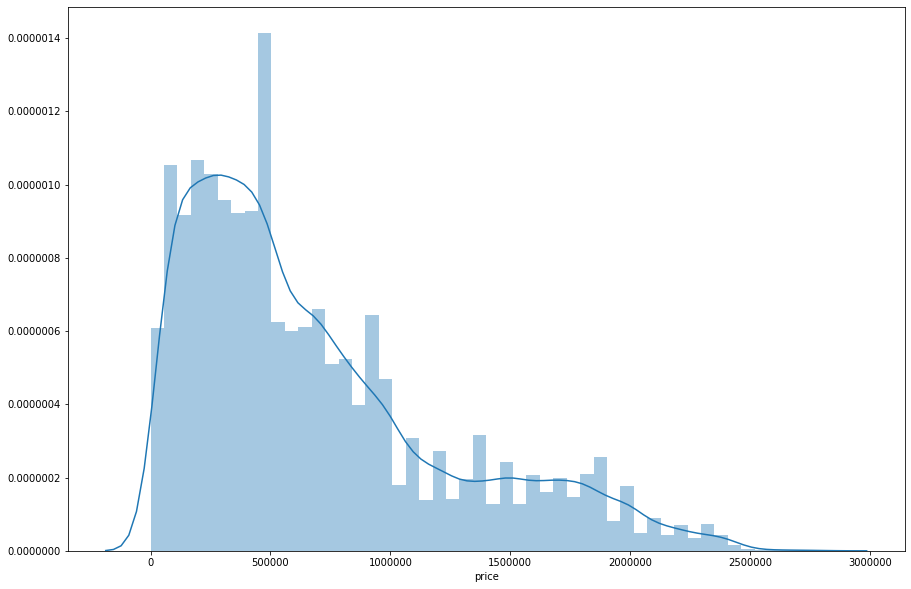

In [5]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(data['price'])

# Data Preprocessing

The first step in each Machine Learning project is data preprocessing. Here we are going through this to make the best out of the given data. I will explain what I am done for this part:

* **Brand and City**: Brand and City are categorical data and we can deal with them with two different approaches. The first one is using `label encoding`, which assigns one number to each category. The second one is using `one-hot encoding`, which will assign different columns to each category. Before we start transforming our data, it is important to figure out if the feature we are working on is `ordinal` or `nominal`. An ordinal feature is best described as a feature with natural, ordered categories and the distances between the categories is not known. We can use LabelEncoder for ordinal features not nominal features. But in nominal features we can’t replace the categories by a number since this would imply the features have an order, which is untrue in case of Brand and City. So we should use a nominal encoding. The most popular way to encode nominal features is one-hot-encoding. Essentially, each categorical feature with n categories is transformed into n binary features. If the cardinality of the categorical features is low (relative to the amount of data) one-hot encoding will work best. But if the cardinality is large and the dataset is small, one-hot encoding may not be feasible, and regressor may not be able to efficiently learn. I implement both method and I will compare them using `Mutual Infomation` soon.


* **Desc and Title**: These features are text written in the Persian language. But there are some English words between them that are mostly models of the cellphones. So, I decided to separate English and Persian to do some operation on them separately. I will explain them in the `Feature extraction` part. At first, I delete punctuation and replace them with nothing to get rid of them. Then, I find English words and convert them to lowercase and then delete the ones with just one letter because they can't give us any information. Then, I separate Persian words and do some works on them. At first, I use Normalization, tokenization, deleting stop words, and lemmatization, respectively. I explained what Stemming and Lemmatization are in the end of this section and I use the former because it work better. After these steps, I have two clean columns for Persian and English words and I can use them in the feature extraction phase.


* **image_count and created_at**: These two features seem useless in our problem because they can't give us any information on the price of the cellphones. So, I delete created_at in this step and show you that image_count is useless too in the `Mutual Information` part.

#### Stemming
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

#### Lemmatization
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [6]:
def dataPreprocessing(data):
    
    stop_words = codecs.open('stopwords', encoding='utf-8').read().split('\n')

    OneHotEncodeOfBrand = pd.get_dummies(data.brand)
    OneHotEncodeOfCity = pd.get_dummies(data.city)
    
    data['desc'] = data['desc'].apply(lambda elem: elem.translate(str.maketrans('', '', string.punctuation)))
    data['title'] = data['title'].apply(lambda elem: elem.translate(str.maketrans('', '', string.punctuation)))
    
    data['english words'] = data['desc'].apply(lambda text : (" ".join(re.findall("[0-9a-zA-Z]+", text))).lower().split()) + data['title'].apply(lambda text : (" ".join(re.findall("[0-9a-zA-Z]+", text))).lower().split())
    data['english words'] = data['english words'].apply(lambda words: [word for word in words if len(word) > 2])    
    
    normalizer = Normalizer(persian_numbers = False)
    data['processed desc'] = data['desc'].apply(normalizer.normalize)
    data['processed title'] = data['title'].apply(normalizer.normalize)
    
    data['processed desc'] = data['processed desc'].apply(word_tokenize)
    data['processed title'] = data['processed title'].apply(word_tokenize)
    
    data['processed text'] = data['processed desc'] + data['processed title']
    
    data['processed text'] = data['processed text'].apply(lambda words: [word for word in words if not word.isascii()])
    
    stop_words = codecs.open('stopwords', encoding='utf-8').read().split('\n')
    data['processed text'] = data['processed text'].apply(lambda words: [word for word in words if word not in (stop_words)])
    
    lemmatizer = Lemmatizer()
    data['processed text'] = data['processed text'].apply(lambda words: [lemmatizer.lemmatize(i) for i in words])

    le = LabelEncoder()
    
    le.fit(data['brand'].astype(str))
    data['Brand Number'] = le.transform(data['brand'].astype(str))
    
    le.fit(data['city'].astype(str))
    data['City Number'] = le.transform(data['city'].astype(str))
    
    scaler = StandardScaler()
    data['City Number'] = scaler.fit_transform(data['City Number'].values.reshape(-1,1))
    
    data = data.drop(columns = [data.columns[0], 'created_at', 'brand', 'city', 'processed desc', 'processed title'])
  
    return data, OneHotEncodeOfBrand, OneHotEncodeOfCity

data, OneHotEncodeOfBrand, OneHotEncodeOfCity = dataPreprocessing(data)
data.head()

,title,desc,image_count,price,english words,processed text,Brand Number,City Number
0,نوکیا6303,سلامیه گوشیه6303سالم که فقط دوتا خط کوچیک رو ا...,2,60000,"[6303, 6303]","[سلامیه, گوشیه, سالم, دوتا, خط, کوچیک, ال, سی,...",5,-0.047405
1,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1150000,[],"[درحد, نو, سالم, اصلى, ضربه, مهلت, تست, میدم, ...",0,1.028868
2,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,590000,[],"[گوشى, بسیار, بسیار, تمیز, هفته, کارکرده, حد, آک]",6,-0.406163
3,گرى 5s ایفون 32گیگ,گلس پشت و رو کارت اپل ای دی لوازم جانبی اصلی م...,3,1100000,[],"[گلس, پشت, کارت, اپل, دی, لوازم, جانبی, اصل, م...",0,-1.123678
4,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,900000,"[galaxy, gold]","[کاملا, تمیز, حتی, خط, خش, همراه, گلاس, قاب, م...",6,1.028868


# Spliting Train and Test Data

In the next step, we should extract as many features as we can from our data. If we extract good features from our data we can train better models and it means fewer errors we got in each of our results. For extracting features, we should first separate train and test data set because we are going to test our test dataset and we shouldn't use it in extracting features.

In [7]:
columns = [x for x in data.columns if x not in ['price']]

X = data[columns] 
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Feature extraction

The next step in each machine learning project is the extraction of features. This phase is very important because it has a direct effect on how much our model has errors. So we should do our best in this phase. One method of feature extraction is using of `bag of words`, but here we can't use it because we have lots of unique words, about `70000` just Persian, and we have that much data to handle this much features. So, here I find the frequency of appearance of each word and select most 200 frequent words for English words and most 300 frequent words for Persian words. With this, we have 500 features that are representing how many words come in the text and it is possible that these words can be useful in training our model. After selecting the most frequent words, I normalized numbers of their appearance because they were large numbers and maybe biased our models.

One popular method in feature extraction is the `TF-IDF` method, which somehow works like the work I do here manually and we got familiar with it in our third computer assignment. But it has some drawbacks which I will explain them more at the end of the project.

In [8]:
def count_english_word(data):
    
    words = dict()
    def increment(word):
        words[word] = 1 + words.get(word, 0)
    
    data['english words'].apply(lambda words: [increment(word) for word in words])

    sorted_count = sorted(words.items(), key=lambda kv: kv[1], reverse=True)
    sorted_count = sorted_count[:200]
    
    count = [x[1] for x in sorted_count]
    words = [x[0] for x in sorted_count]
    
    normalize_count = [float(i)/sum(count) for i in count]
    
    english_counted_word = dict(zip(words, normalize_count))
    
    return english_counted_word

english_counted_word = count_english_word(X_train)
random_keys = random.sample(english_counted_word.keys(),10)
temp = [print(key, english_counted_word[key]) for key in random_keys]

super 0.0011887151310228234
620 0.000977387996618766
422 0.0025095097210481826
550 0.000977387996618766
310 0.0008717244294167371
350 0.0010302197802197802
g630 0.004120879120879121
mini 0.005653000845308538
128g 0.001452874049027895
iphone6s 0.0011094674556213018


In [9]:
def persian_word_feature(data):
    
    words = dict()
    def increment(word):
        words[word] = 1 + words.get(word, 0)
    
    data['processed text'].apply(lambda words: [increment(word) for word in words])

    sorted_count = sorted(words.items(), key=lambda kv: kv[1], reverse=True)
    sorted_count = sorted_count[:300]

    count = [x[1] for x in sorted_count]
    words = [x[0] for x in sorted_count]
    
    normalize_count = [float(i)/sum(count) for i in count]
    
    persian_counted_word = dict(zip(words, normalize_count))
    
    return persian_counted_word

persian_counted_word = persian_word_feature(X_train)
random_keys = random.sample(persian_counted_word.keys(),10)
temp = [print(key, persian_counted_word[key]) for key in random_keys]

خش 0.01925817352713652
نمیدم 0.0009364439558649892
کارکرده 0.0022687277481463386
گذاشت#گذار 0.0015946690552773367
پای 0.0023546815411967484
برچسب 0.001124185135422463
زنگ 0.002024438020529385
قیمت 0.012160199774710584
برای 0.002958620034471995
ویتنام 0.0009387058977873684


In [10]:
def makeWordDataFrame(data, english_counted_word, persian_counted_word):
    word_df = pd.DataFrame()

    for word in english_counted_word.keys():
        word_df[word] = data['english words'].apply(lambda text: [english_counted_word[word] for i in text if i == word])
    
    for word in persian_counted_word.keys():
        word_df[word] = data['processed text'].apply(lambda text: [persian_counted_word[word] for i in text if i == word])
        
    for col in word_df.columns.values:
        word_df[col] = word_df[col].apply(lambda array: array[0] if len(array) > 0 else 0)
    
    return word_df

word_df = makeWordDataFrame(data, english_counted_word, persian_counted_word)
word_df.head()

,num,iphone,lla,htc,gold,galaxy,samsung,2016,16g,sony,...,آب,فاکتور,عامل,وتمیز,بدین,بدنه,حالا,کابل,چرم,دوماه
0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.03059,0.025967,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Mutual Information

Now is the time to evaluate our features power. We use the `Regression Mutual Infomation` method here, which is similar to the `Information Gain`, but it is for continuous problems. The words that we extract are very a lot and surely they have very low mutual information and here I don't calculate them. Here as it's obvious from the figure below, `Brand One-Hot encoding` has the best mutual information value and so I use this feature. But `City One-Hot Encoding` doesn't have a notable difference with `City Label Encode` and because I don't want to add not required columns to our dataset, I use its label encode feature. Here we can see that `image_count` has very low mutual information so, it is useless in our model and I remove it from my dataset.

In [11]:
features = ['City Number', 'Brand Number', 'image_count']
X = data[features]
y = data['price']
information_gain = mutual_info_regression(X, y, random_state = 10)
OneHotEncodeofBrandInformation_gain = mutual_info_regression(OneHotEncodeOfBrand, y, random_state = 10)
OneHotEncodeofCityInformation_gain = mutual_info_regression(OneHotEncodeOfCity, y, random_state = 10)

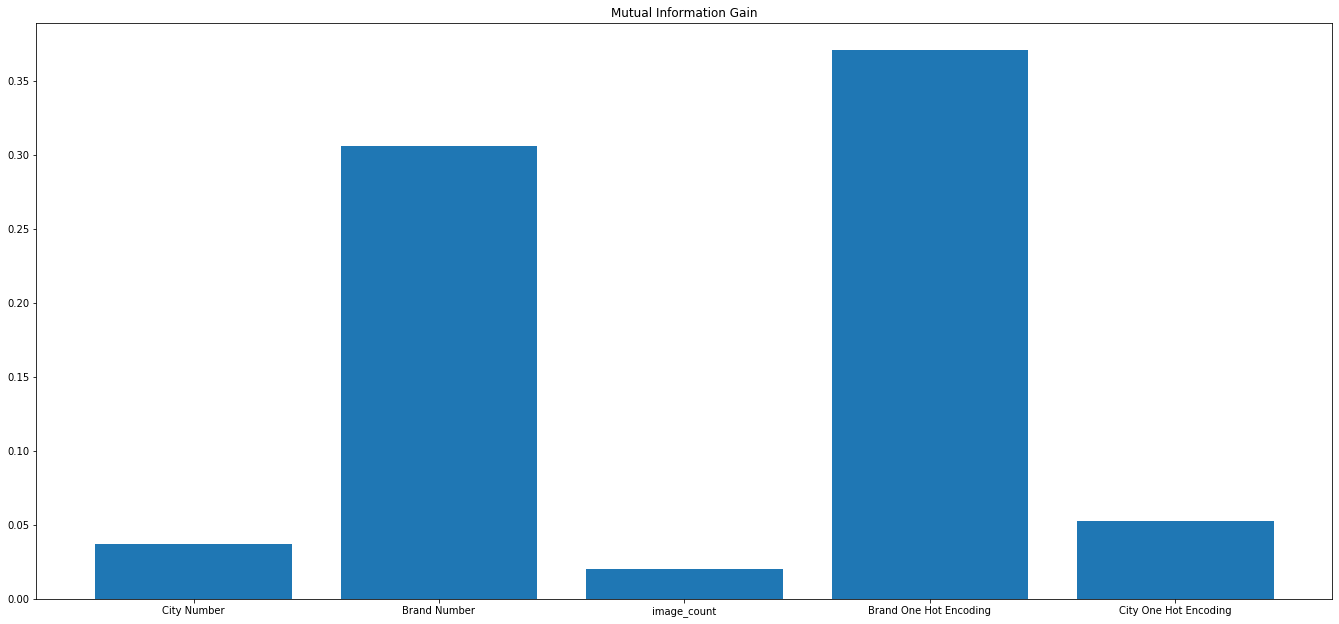

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.bar(np.concatenate((features, ['Brand One Hot Encoding', 'City One Hot Encoding'])), np.concatenate((information_gain, [sum(OneHotEncodeofBrandInformation_gain), sum(OneHotEncodeofCityInformation_gain)])))
plt.title('Mutual Information Gain')
plt.show()

# Training

Now we are going to train our model with different algorithm. At first I seperate train and test data again to make a dataset I want to be trained. I use same `random_state` value and it will return same data as last phases. I define two functions for `evaluation` the result and `showing` some samples of predicted values.

In [13]:
columns = ['City Number']

X = data[columns] 
X = X.join(OneHotEncodeOfBrand)
X = X.join(word_df)

y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train.head()

,City Number,Apple::اپل,HTC::اچ‌تی‌سی,Huawei::هوآوی,LG::ال‌جی,Lenovo::لنوو,Nokia::نوکیا,Samsung::سامسونگ,Sony::سونی,ZTE::زدتی‌ای,...,آب,فاکتور,عامل,وتمیز,بدین,بدنه,حالا,کابل,چرم,دوماه
5049,1.028868,1,0,0,0,0,0,0,0,0,...,0.0,0.000726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18372,1.028868,0,0,0,0,0,0,1,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35287,-0.406163,0,0,0,0,0,0,1,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34879,-0.406163,0,0,0,0,0,0,0,1,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50914,0.670110,0,0,0,0,0,0,1,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Evaluation Metrics

Here I use three metrics for evaluation `Mean Absolute Error`, `Mean Squared Error`, and `Root Mean Squared Error`. MSE in our problem is very big and can't give us much information. But about MAE and RMSE:

* **Mean Squared Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

<img src="Images/MAE.gif" width="250px" />

* **Root Mean Squared Error**: RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.
<img src="Images/RMSE.png"  width="250px"/>

They are almost the same but the difference between them is:

**Differences**: Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. The three tables below show examples where MAE is steady and RMSE increases as the variance associated with the frequency distribution of error magnitudes also increases.

In our problem, I think because we have very large numbers it is better to work with `MAE`.

In [14]:
def evaluation(y_train, train_predict, y_test, test_predict):

    table = pd.DataFrame([], index=['Mean Absolute Error','Mean Squared Error', 'Root Mean Squared Error'], columns=['Train Dataset', 'Test Dataset'])
    
    table.loc['Mean Absolute Error']['Train Dataset'] = metrics.mean_absolute_error(y_train, train_predict)
    table.loc['Mean Absolute Error']['Test Dataset'] = metrics.mean_absolute_error(y_test, test_predict)
    
    table.loc['Mean Squared Error']['Train Dataset'] = metrics.mean_squared_error(y_train, train_predict) 
    table.loc['Mean Squared Error']['Test Dataset'] = metrics.mean_squared_error(y_test, test_predict)
    
    table.loc['Root Mean Squared Error']['Train Dataset'] = np.sqrt(metrics.mean_squared_error(y_train, train_predict))
    table.loc['Root Mean Squared Error']['Test Dataset'] = np.sqrt(metrics.mean_squared_error(y_test, test_predict))
    
    return table

In [15]:
def show_test_result(y_test, test_predict):    
    test_df = pd.DataFrame({'Test Actual': y_test, 'Test Predicted': test_predict}).sample(n = 10)
    return test_df

## Linear Regression

The most simple way of traning a regression model is using the `Linear Regression` algorrithm. This Algorithm hasn't any specific parameter to tune. LinearRegression fits a linear model with coefficients to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:
<img src="Images/Linear.png" width="250"/>

The result is not very bad, but we should use more complex models because our model isn't linear.

In [16]:
def LinearRegressionMethod(X_train, X_test, y_train, y_test):
    
    linear_regression = LinearRegression()
    linear_regression = linear_regression.fit(X_train, y_train)
    test_predict = linear_regression.predict(X_test)
    train_predict = linear_regression.predict(X_train)
   
    return test_predict, train_predict
    
test_predict, train_predict = LinearRegressionMethod(X_train, X_test, y_train, y_test)
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,255176,261138
Mean Squared Error,1.23382e+11,1.30098e+11
Root Mean Squared Error,351258,360690


In [17]:
result = show_test_result(y_test, test_predict)
result

,Test Actual,Test Predicted
3676,700000,1132592.0
1538,20000,210288.0
55206,450000,837456.0
4979,550000,606880.0
4529,65000,514272.0
30970,750000,769376.0
35612,750000,1133168.0
16216,600000,278896.0
20974,220000,447200.0
27552,400000,705728.0


## Ridge Regression

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares:

<img src="Images/Ridge.png" width="250" />

As it's obvious from the figure, with lower `alpha` we have better result, so I put the smallest alpha possible as best alpha parameter.

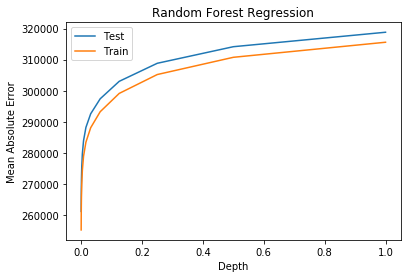

In [18]:
def RidgeRegressionTuning():
    
    trainMAE, testMAE= [], []
    alpha = 1
    alphaList = []
    while alpha > np.finfo(np.float32).eps:
        reg = linear_model.Ridge(alpha = alpha)
        reg = reg.fit(X_train, y_train)
        test_predict = reg.predict(X_test)
        train_predict = reg.predict(X_train)
        testMAE.insert(0, metrics.mean_absolute_error(y_test, test_predict))
        trainMAE.insert(0, metrics.mean_absolute_error(y_train, train_predict))
        alphaList.insert(0, alpha)
        alpha = alpha / 2
        
    plt.plot(alphaList, testMAE, label='Test')
    plt.plot(alphaList, trainMAE, label='Train')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Depth')
    plt.title('Random Forest Regression')
    plt.legend()
    plt.show()
    
RidgeRegressionTuning()

In [19]:
def RidgeRegressionMethod(best_alpha):
    reg = linear_model.Ridge(alpha = best_alpha)
    reg = reg.fit(X_train, y_train)
    test_predict = reg.predict(X_test)
    train_predict = reg.predict(X_train)
    
    return test_predict, train_predict

best_alpha = 0
test_predict, train_predict = RidgeRegressionMethod(best_alpha)
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,255201,261139
Mean Squared Error,1.23383e+11,1.3009e+11
Root Mean Squared Error,351259,360679


## Lasso Regression

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients.
Mathematically, it consists of a linear model with an added regularization term. The objective function to minimize is:
<img src="Images/Lasso.png" width="250"/>

**Elastic-Net Regression**: ElasticNet is a linear regression model trained with both `l1` and `l2`-norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. Here we don't get good result out of Ridge and Lasso, so I didn't try Elastic-Net.

In [20]:
def LassoRegressionMethod():
    reg = linear_model.Lasso(alpha = 0.5)
    reg = reg.fit(X_train, y_train)
    test_predict = reg.predict(X_test)
    train_predict = reg.predict(X_train)
    
    return test_predict, train_predict

test_predict, train_predict = LassoRegressionMethod()
result = evaluation(y_train, train_predict, y_test, test_predict)
result

/Users/navid/Library/Python/3.7/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340476145594936.0, tolerance: 1286473988552.101
  positive)


,Train Dataset,Test Dataset
Mean Absolute Error,261449,266764
Mean Squared Error,1.27873e+11,1.33956e+11
Root Mean Squared Error,357594,366000


## Stochastic Gradient Decent Regression

Stochastic gradient descent is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of features is very large. Here we get very bad result out of this algorithm. This is maybe because we didn't tune our regressor. By tuning its parameters it should work better.

In [21]:
def SGDRegressionMethod():
    reg = linear_model.SGDRegressor()
    reg = reg.fit(X_train, y_train)
    test_predict = reg.predict(X_test)
    train_predict = reg.predict(X_train)
    
    return test_predict, train_predict

test_predict, train_predict = SGDRegressionMethod()
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,329647,333903
Mean Squared Error,1.90268e+11,1.96444e+11
Root Mean Squared Error,436197,443220


# K Nearest Neighbors Regression

Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors. Here we try to tune the `n_neighbors` parameter to finding best number of neighbors in our model.

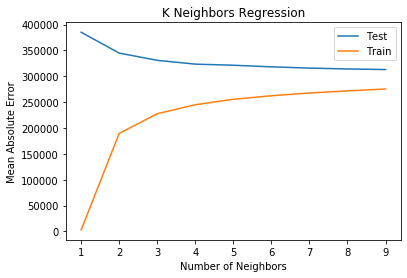

TypeError: cannot unpack non-iterable NoneType object

In [23]:
def KneighborsRegressionTuning():
    
    trainMAE, testMAE= [], []
    bestIndex = 0
    minMAE = float('inf')
    for i in list(range(1,10)):
        KNN = KNeighborsRegressor(n_neighbors=i)
        KNN = KNN.fit(X_train, y_train)
        test_predict = KNN.predict(X_test)
        train_predict = KNN.predict(X_train)
        testMAE.append(metrics.mean_absolute_error(y_test, test_predict))
        if metrics.mean_absolute_error(y_test, test_predict) < minMAE:
            minMAE = metrics.mean_absolute_error(y_test, test_predict)
            bestIndex = i
        trainMAE.append(metrics.mean_absolute_error(y_train, train_predict))

    plt.plot(list(range(1, 10)), testMAE, label='Test')
    plt.plot(list(range(1, 10)), trainMAE, label='Train')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Number of Neighbors')
    plt.title('K Neighbors Regression')
    plt.legend()
    plt.show()
    
KneighborsRegressionTuning()

In [24]:
def KneighborsRegressionMethod(bestNumofNeighbor):
    
    KNN = KNeighborsRegressor(n_neighbors = bestNumofNeighbor)
    KNN = KNN.fit(X_train, y_train)
    test_predict = KNN.predict(X_test)
    train_predict = KNN.predict(X_train)
   
    return test_predict, train_predict

bestNumofNeighbor = 10
test_predict, train_predict = KneighborsRegressionMethod(bestNumofNeighbor)
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,278139,312240
Mean Squared Error,1.46466e+11,1.8427e+11
Root Mean Squared Error,382709,429267


## Decision Tree Regression

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Here, I try to tune `max_depth` parameter to find best depth that our model can train. As we can see from result after tenth depth, data get overfitted. So, I use `10` as best depth for our model.

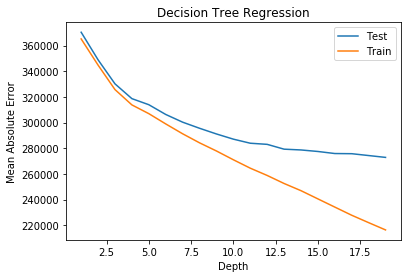

In [25]:
def DecisionTreeRegressionTuning():
    
    trainMAE, testMAE= [], []
    bestIndex = 0
    minMAE = float('inf')
    for i in list(range(1,20)):
        reg = tree.DecisionTreeRegressor(max_depth=i)
        reg = reg.fit(X_train, y_train)
        test_predict = reg.predict(X_test)
        train_predict = reg.predict(X_train)
        testMAE.append(metrics.mean_absolute_error(y_test, test_predict))
        if metrics.mean_absolute_error(y_test, test_predict) < minMAE:
            minMAE = metrics.mean_absolute_error(y_test, test_predict)
            bestIndex = i
        trainMAE.append(metrics.mean_absolute_error(y_train, train_predict))

    plt.plot(list(range(1, 20)), testMAE, label='Test')
    plt.plot(list(range(1, 20)), trainMAE, label='Train')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Depth')
    plt.title('Decision Tree Regression')
    plt.legend()
    plt.show()

DecisionTreeRegressionTuning()

In [26]:
def DecisionTreeRegressionMethod(best_depth):
    reg = tree.DecisionTreeRegressor(max_depth = best_depth)
    reg = reg.fit(X_train, y_train)
    test_predict = reg.predict(X_test)
    train_predict = reg.predict(X_train)
    
    return test_predict, train_predict

best_depth = 10
test_predict, train_predict = DecisionTreeRegressionMethod(best_depth)
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,271047,286926
Mean Squared Error,1.40768e+11,1.60528e+11
Root Mean Squared Error,375191,400659


## Random Forest Regression

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size `max_features`.  Here, I try to tune `max_depth` parameter to find best depth that our model can train. As we can see from result as depth go further, we have better result. So, I use `20` as best depth for our model. If I have more time I would check for best depth.

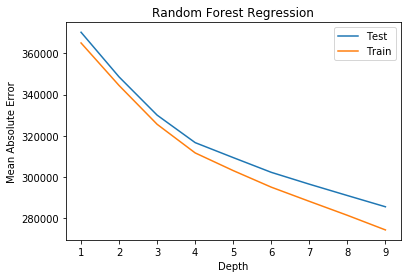

In [29]:
def RandomForestRegressionTuning():
    
    trainMAE, testMAE= [], []
    bestIndex = 0
    minMAE = float('inf')
    for i in list(range(1,10)):
        RFreg = RandomForestRegressor(max_depth=i)
        RFreg = RFreg.fit(X_train, y_train)
        test_predict = RFreg.predict(X_test)
        train_predict = RFreg.predict(X_train)
        testMAE.append(metrics.mean_absolute_error(y_test, test_predict))
        if metrics.mean_absolute_error(y_test, test_predict) < minMAE:
            minMAE = metrics.mean_absolute_error(y_test, test_predict)
            bestIndex = i
        trainMAE.append(metrics.mean_absolute_error(y_train, train_predict))

    plt.plot(list(range(1, 10)), testMAE, label='Test')
    plt.plot(list(range(1, 10)), trainMAE, label='Train')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Depth')
    plt.title('Random Forest Regression')
    plt.legend()
    plt.show()
    
RandomForestRegressionTuning()

In [30]:
def RandomForestRegressionMethod(best_depth):
    reg = RandomForestRegressor(max_depth = best_depth)
    reg = reg.fit(X_train, y_train)
    test_predict = reg.predict(X_test)
    train_predict = reg.predict(X_train)
    
    return test_predict, train_predict, reg

best_depth = 20
test_predict, train_predict, reg = RandomForestRegressionMethod(best_depth)
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,213348,254664
Mean Squared Error,8.99859e+10,1.3051e+11
Root Mean Squared Error,299977,361262


## Implementation of TF-IDF method

As I said earlier, one method for dealing with text and extracting features is the `TF-IDF` method. Here, I use this method for training a model but it got overfitted and is not a good model to use. But the way I implement it is the easiest way that can be implemented, by using more complex methods and other features maybe it got better. I didn't have time to work on it. Here I explain how this method work:

Suppose we have a document(or a collection of documents i.e, corpus), and we want to summarize it using a few keywords only. In the end, we want some method to compute the importance of each word.
One way to approach this would be to count the no. of times a word appears in a document. So, the word’s importance is directly proportional to its frequency. This method is, therefore, called Term Frequency(TF).
<img src="Images/1.png" width="320"/>
This method fails in practical use as words like “the”, “an”, “a”, etc. will almost always be the result of this method, as they occur more frequently. But of course, they are not the right way to summarize our document.
We also want to take into consideration how unique the words are, this method is called Inverse Document Frequency(IDF).
<img src="Images/2.png" width="320"/>
So, the product of TF and IDF will give us a measure of how frequent the word is in a document multiplied by how unique the word is, giving rise to Term Frequency-Inverse Document Frequency(TF-IDF) measure.<a href="https://medium.com/@hritikattri10/feature-extraction-using-tf-idf-algorithm-44eedb37305e">[1]</a>
<img src="Images/3.png" width="200"/>

As its shown in the formula, in our model we calculated the TF and we just need to calculate the IDF and multiply it with the TF. So, we can calculate it in the Likelihood.


In [31]:
def TF_IDFMethod():
    data['text'] = data['desc'] + data['title']
    tf_X = data['text']
    tf_y = data['price']
    tf_X_train, tf_X_test, tf_y_train, tf_y_test = train_test_split(tf_X, tf_y, test_size=0.2, random_state=10)

    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearRegression())])

    text_clf.fit(tf_X_train, tf_y_train)
    test_predict = text_clf.predict(tf_X_test)
    train_predict = text_clf.predict(tf_X_train)

    return test_predict, train_predict
test_predict, train_predict = TF_IDFMethod()
result = evaluation(y_train, train_predict, y_test, test_predict)
result

,Train Dataset,Test Dataset
Mean Absolute Error,36670.2,429836
Mean Squared Error,1.02034e+10,3.74131e+11
Root Mean Squared Error,101012,611662


# Evaluation of Validation data

Here, I used the best model we have through all regression models and predict the validation data and save them in one csv file

In [32]:
def validation_result(validation_predict):    
    validation_df = pd.DataFrame({'Validation Predicted': validation_predict})
    return validation_df

In [33]:
validation_data, validation_OneHotEncodeOfBrand, validation_OneHotEncodeOfCity = dataPreprocessing(validation_data)
validation_word_df = makeWordDataFrame(validation_data, english_counted_word, persian_counted_word)

columns = ['City Number']

X_validation = validation_data[columns] 
X_validation = X_validation.join(validation_OneHotEncodeOfBrand)
X_validation = X_validation.join(validation_word_df)
X_validation.head()

,City Number,Apple::اپل,HTC::اچ‌تی‌سی,Huawei::هوآوی,LG::ال‌جی,Lenovo::لنوو,Nokia::نوکیا,Samsung::سامسونگ,Sony::سونی,ZTE::زدتی‌ای,...,آب,فاکتور,عامل,وتمیز,بدین,بدنه,حالا,کابل,چرم,دوماه
23,-1.135717,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,-0.070722,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.284276,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,-0.070722,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.994273,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
validation_predict = reg.predict(X_validation)

In [35]:
result = validation_result(validation_predict)
result.head()

,Validation Predicted
0,703987.057502
1,985996.857077
2,952223.987935
3,449456.294967
4,342411.401044


In [36]:
result.to_csv('ValidationResult.csv')

# Ideas for Improving

Here I explain some improving idea:
    
* **Neural Network**: In this project, we could use the Neural Network algorithm to find the best model for our data, but because of the little time we had for this project, it was very risky and maybe we couldn't find a good model for our data. Because finding a good Neural Network model is a hard problem and need an expert to fit a good model to data.

* **TF-IDF**: Here, I use the simplest `TF-IDF` method with the most basic regressor. By using a better algorithm and combining it with other features, maybe we can find a good model.

* **Using More Complex Regression Method**: Here, I use a simple algorithm of regression by using more complex methods, maybe we could have a better model.